#### Notebook 2

- Monthly and seasonal verification of model simulations

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import rioxarray
import cartopy
import pyproj
import numpy as np
import xskillscore

import util

##### Variable options

var_type:
- single or pressure

var:
- single: t2m, prec
- pressure: t, relhum, geopotential

In [97]:
var_type = 'single'
var = 't2m'
start_date = '2008-06-01'
end_date = '2009-02-28'
agg_by = 'mean' # aggregation type 
agg_for = '1M' # aggregate for

Retrieve aggregated ERA5 and model files

In [98]:
da_model, da_era = util.get_model_era_files(var_type=var_type, var=var,
                                            start_date=start_date, end_date=end_date,)
                                            #aggregate="6H")

Regrid and interpolate ERA5 data to the model grid

In [99]:
# regrid
model_proj = util.ModelProj().crs_info_model # crs info for the model
era_proj = 4326 # input esg code for era

da_model, da_era = util.regrid_match(da_model, da_era,
                                     model_proj, era_proj)

In [100]:
# interpolate
rlat, rlon, time = da_model.indexes.values()
da_era = da_era.interp(rlon=rlon, rlat=rlat, method="nearest") # interp to model grid

In [101]:
if var=="prec":
    da_era = da_era*1000 # m to mm

##### Monthly Verification

In [18]:
da_model_aggr = util.aggregate_file(da_model, agg_by, agg_for)
da_era_aggr = util.aggregate_file(da_era, agg_by, agg_for)

In [20]:
da_monthly_verif = (da_model_aggr - da_era_aggr)

In [21]:
da_monthly_verif.time

<xarray.DataArray 'time' (time: 9)>
array(['2008-06-30T00:00:00.000000000', '2008-07-31T00:00:00.000000000',
       '2008-08-31T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2008-10-31T00:00:00.000000000', '2008-11-30T00:00:00.000000000',
       '2008-12-31T00:00:00.000000000', '2009-01-31T00:00:00.000000000',
       '2009-02-28T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 2008-06-30 2008-07-31 ... 2009-02-28
    rotated_pole  int64 0
    spatial_ref   int64 0

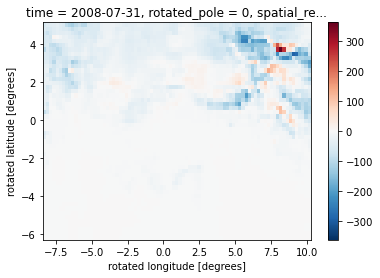

In [22]:
da_monthly_verif.isel(time=1).plot()

Save the prepared verification file

In [23]:
prepath = 'data/post_processed/'
util.save_verif_file(da=da_monthly_verif, var=var,
                     prepath=prepath, verif_type='monthly')

'model_prec_monthly_verif.nc created'

##### Seasonal Verification

- Seasonal mean of monthly values

In [102]:
da_model_aggr = util.aggregate_file(da_model, agg_by, agg_for)
da_era_aggr = util.aggregate_file(da_era, agg_by, agg_for)

In [103]:
da_model_seasonal = da_model_aggr.groupby("time.season").mean(dim="time")
da_era_seasonal = da_era_aggr.groupby("time.season").mean(dim="time")

In [104]:
da_model_seasonal.season.values

array(['DJF', 'JJA', 'SON'], dtype=object)

In [105]:
da_seasonal_verif = (da_model_seasonal - da_era_seasonal)

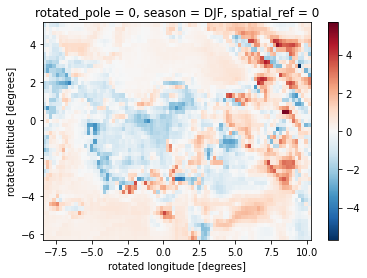

In [106]:
da_seasonal_verif.sel(season="DJF").plot()

Save the prepared verification file

In [107]:
prepath = 'data/post_processed/'
util.save_verif_file(da=da_seasonal_verif, var=var,
                     prepath=prepath, verif_type='seasonal')

'model_t2m_seasonal_verif.nc created'